# How robustness is affected by changing activation functions (elu, kaf, kwta)  

* Craft a PGD-attack for each model from models.ipynb and evaluate robustness
* TODO: Same for a iterative FSG attack
* Plot activations distributions in presence and absence of an attack. Do they differ?

In [2]:
# Imports
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt

import activationsf

In [3]:
!unzip ./relu_lightmodel.zip
!unzip ./kaf_lightmodel.zip

Archive:  ./relu_lightmodel.zip
   creating: saved_custom_model/relu_cnn/
  inflating: saved_custom_model/relu_cnn/saved_model.pb  
   creating: saved_custom_model/relu_cnn/variables/
  inflating: saved_custom_model/relu_cnn/variables/variables.data-00000-of-00001  
  inflating: saved_custom_model/relu_cnn/variables/variables.index  
   creating: saved_custom_model/relu_cnn/assets/
Archive:  ./kaf_lightmodel.zip
   creating: saved_custom_model/kaf_cnn/
  inflating: saved_custom_model/kaf_cnn/saved_model.pb  
   creating: saved_custom_model/kaf_cnn/variables/
  inflating: saved_custom_model/kaf_cnn/variables/variables.data-00000-of-00001  
  inflating: saved_custom_model/kaf_cnn/variables/variables.index  
   creating: saved_custom_model/kaf_cnn/assets/


In [4]:
!unzip ./kwta_lightmodel.zip

Archive:  ./kwta_lightmodel.zip
   creating: saved_custom_model/kwta_cnn/
  inflating: saved_custom_model/kwta_cnn/saved_model.pb  
   creating: saved_custom_model/kwta_cnn/variables/
  inflating: saved_custom_model/kwta_cnn/variables/variables.data-00000-of-00001  
  inflating: saved_custom_model/kwta_cnn/variables/variables.index  
   creating: saved_custom_model/kwta_cnn/assets/


In [5]:
# Load models and data
from tensorflow.keras.datasets import cifar10

relu_cnn = tf.keras.models.load_model('./saved_custom_model/relu_cnn')
kaf_cnn = tf.keras.models.load_model('./saved_custom_model/kaf_cnn', custom_objects={'Kaf':activationsf.Kaf})
kwta_cnn = tf.keras.models.load_model('./saved_custom_model/kwta_cnn', custom_objects={'Kwta':activationsf.Kwta})

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train/ 255.0, x_test/ 255.0

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5
170500096/170498071 [==============================] - 4s 0us/step


In [8]:
# Accuracy on test set
relu_cnn.evaluate(x_test, y_test, batch_size=32)
kaf_cnn.evaluate(x_test, y_test, batch_size=32)
kwta_cnn.evaluate(x_test, y_test, batch_size=32)

313/313 [==============================] - 4s 12ms/step - loss: 1.0239 - sparse_categorical_accuracy: 0.6533


[1.0239452123641968, 0.6532999873161316]

### Crafting a PGD Attack (Skip this part till robustness eval if attacks are already computed in ./attacks) 

In [ ]:
# We use the IBM Adversarial Robustness 360 Toolbox
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 655kB 9.3MB/s 
     |████████████████████████████████| 235kB 23.9MB/s 
     |████████████████████████████████| 6.8MB 29.3MB/s 
     |████████████████████████████████| 20.8MB 159kB/s 
     |████████████████████████████████| 747kB 47.2MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
from art.classifiers import TensorFlowV2Classifier
from art.attacks.evasion import ProjectedGradientDescent

# Wrap the model in a TensorFlowV2Classifier object
relu_cnn_art = TensorFlowV2Classifier(model=relu_cnn, nb_classes=10, input_shape=(32, 32, 3), loss_object=tf.keras.losses.SparseCategoricalCrossentropy(), clip_values=(0, 1))
kaf_cnn_art = TensorFlowV2Classifier(model=kaf_cnn, nb_classes=10, input_shape=(32, 32, 3), loss_object=tf.keras.losses.SparseCategoricalCrossentropy(), clip_values=(0, 1))
kwta_cnn_art = TensorFlowV2Classifier(model=kwta_cnn, nb_classes=10, input_shape=(32, 32, 3), loss_object=tf.keras.losses.SparseCategoricalCrossentropy(), clip_values=(0, 1))

In [ ]:
# Set up a PGD attack w/ parameters as described in https://arxiv.org/pdf/1905.10510.pdf for each model
pgd_relu = ProjectedGradientDescent(relu_cnn_art, eps=0.031, eps_step=0.003, max_iter=40, num_random_init=40, norm=np.inf)
pgd_kaf = ProjectedGradientDescent(kaf_cnn_art, eps=0.031, eps_step=0.003, max_iter=40, num_random_init=40, norm=np.inf)
pgd_kwta = ProjectedGradientDescent(kwta_cnn_art, eps=0.031, eps_step=0.003, max_iter=40, num_random_init=40, norm=np.inf)

In [ ]:
# If loaded, every output of subsequent cell execution will include the time in min and sec it took to execute it.
!pip install ipython-autotime
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1831 sha256=ddd9eb8f71cb468c6f52126f1e882dff55a1d290c55e654a00fb1fcba9189623
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [ ]:
# Actually compute PGDs (takes around 1h each with GTX1050Ti)

# For testing purposes use a much smaller amount of samples ie 1000
sample_ids = np.random.randint(10000, size=1000)
x_test_sample = x_test[sample_ids, :, :, :]

relu_x_adv = pgd_relu.generate(x_test_sample)
kwta_x_adv = pgd_kwta.generate(x_test_sample)
kaf_x_adv = pgd_kaf.generate(x_test_sample)

# Save attacks
np.save('./relu_pgd.npy', relu_x_adv)
np.save('./kwta_pgd.npy', kwta_x_adv)
np.save('./kaf_pgd.npy', kaf_x_adv)

# Download em if on Colab
from google.colab import files
files.download('./kwta_pgd.npy')
files.download('./relu_pgd.npy')
files.download('./kaf_pgd.npy')

### Evaluate Robustness 

In [6]:
# Load computed adversarial examples
relu_x_adv = np.load('./relu_pgd.npy') 
kwta_x_adv = np.load('./kwta_pgd.npy') 
kaf_x_adv = np.load('./kaf_pgd.npy') 

In [7]:
def find_original_img(perturbed_img):
    """Retrieve original image id given an adversarial example""" 
    min_diff = np.math.inf
    index = 0
    
    for i in range(0, x_test.shape[0]):
        diff = np.sum(abs(perturbed_img - x_test[i]))
        if diff < min_diff:
            min_diff = diff
            index = i
            
    return index

In [8]:
# CIFAR10 Classes
classes = ['airplane', 
           'automobile', 
            'bird', 
            'cat', 
            'deer', 
            'dog', 
            'frog', 
            'horse', 
            'ship', 
            'truck']

In [ ]:
def attack_succeed(original_img, idx, perturbed_img, model, plot = False):
    """
        Return 0 if the model has been fooled 1 otherwise. Plot True if you want more info on the error margin
    """

    if plot:
        # Plot original img alongside with the perturbed one
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(original_img);
        ax[0].title.set_text('Original')
        ax[0].axis('off')
        ax[1].imshow(perturbed_img)
        ax[1].title.set_text('Perturbed')
        ax[1].axis('off')
        plt.show()
        plt.close()

    # Predict
    perturbed_img = tf.expand_dims(perturbed_img, 0)

    original = classes[y_test[idx][0]]
    perturbed = classes[np.argmax(model.predict(perturbed_img))]

    if plot:
        print("Real class: {}".format(original))
        print("Predicted class: {} with {} confidence".format(perturbed , round(np.max(model.predict(perturbed_img)) * 100)) )

    return (original == perturbed)

time: 11.2 ms


In [ ]:
# Robustness Accuracy for relu_cnn model, set plot=True if you want image-wise stats
nfool = 0
nacc = 0
for perturbed_img in relu_x_adv:
    
    original_idx = find_original_img(perturbed_img)
    nfool += attack_succeed(x_test[original_idx], original_idx, perturbed_img, relu_cnn, plot=False) 
    nacc += attack_succeed(x_test[original_idx], original_idx, x_test[original_idx], relu_cnn, plot=False) 

print("relu CNN original Accuracy {}%\nRobustness relu CNN {}%".format(nacc/1000, nfool/1000))

relu CNN original Accuracy 0.763%
Robustness relu CNN 0.112%
time: 4min 55s


In [ ]:
# Robustness Accuracy for kwta_cnn model
nfool = 0
nacc = 0
for perturbed_img in kwta_x_adv:
    
    original_idx = find_original_img(perturbed_img)
    nfool += attack_succeed(x_test[original_idx], original_idx, perturbed_img, kwta_cnn, plot=False) 
    nacc += attack_succeed(x_test[original_idx], original_idx, x_test[original_idx], kwta_cnn, plot=False) 

print("KWTA CNN original Accuracy {}%\nRobustness KWTA CNN {}%".format(nacc/1000, nfool/1000))

KWTA CNN original Accuracy 0.673%
Robustness KWTA CNN 0.132%
time: 3min 15s


In [ ]:
# Robustness Accuracy for kaf_cnn model
nfool = 0
nacc = 0
for perturbed_img in kaf_x_adv:
    
    original_idx = find_original_img(perturbed_img)
    nfool += attack_succeed(x_test[original_idx], original_idx, perturbed_img, kaf_cnn, plot=False) 
    nacc += attack_succeed(x_test[original_idx], original_idx, x_test[original_idx], kaf_cnn, plot=False) 

print("KAF CNN original Accuracy {}%\nRobustness KAF CNN {}%".format(nacc/1000, nfool/1000))

KAF CNN original Accuracy 0.689%
Robustness KAF CNN 0.157%
time: 3min 22s


In [ ]:
# Note: here the KAF-net seems to be even more robust than Kwta-net!

## How much does the attack affect activations ?

In [9]:
# Similar function as before but for a batch of adversarial examples
def find_original_ids(perturbed_imgs):
    """Retrive the initially sampled images from a batch of adversarial examples"""    
    original_ids = []
    for img in perturbed_imgs:
        original_ids.append(find_original_img(img))
    
    return x_test[original_ids, :, :, :]

# Get original examples from each attack
relu_test_sample = find_original_ids(relu_x_adv)
kaf_test_sample = find_original_ids(kaf_x_adv)
kwta_test_sample = find_original_ids(kwta_x_adv)

In [10]:
# Compute the activation to the layer of a model for a given input

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers, regularizers

def get_hidden_layer_input(model, l_name, inputs, fixed=False):
  ''' Build a sub model of model from buttom layer up to layer l_name.inputs, and return activations to l_name given "inputs" as input'''
  l_inp = model.get_layer(name = l_name).input
  
  if not fixed:
    hidden_model = Model(model.inputs, l_inp)
  
  else: # We need special care when the layer uses a fixed activation function 
    wgts = model.get_layer(name = l_name).get_weights()
    if 'conv' in l_name:
      
      nfilters = model.get_layer(name = l_name).filters
      #recreate the conv2d layer
      if l_name == 'conv2d': #first layer in the model need to add input_shape attribute
        out = layers.Conv2D(nfilters, 3, padding='same', name='out', activation=None, kernel_initializer='he_uniform', input_shape = (32, 32, 3)) (l_inp)
      else:
        out = layers.Conv2D(nfilters, 3, padding='same', name = 'out', activation=None, kernel_initializer='he_uniform') (l_inp)
    
    else:
      nfilters = model.get_layer(name = l_name).units
      #recreate the dense layer
      out = layers.Dense(nfilters, name = 'out', activation=None, kernel_regularizer=regularizers.l2(0.0012)) (l_inp)

    #create the new model
    hidden_model = Model(model.inputs, out)
    #set weights from old layer
    hidden_model.get_layer(name = 'out').set_weights(wgts)
  
  return hidden_model.predict(inputs)

In [11]:
# Same for the output instead of the activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers, regularizers

def get_hidden_layer_output(model, l_name, inputs):
  ''' Build a sub model of model from buttom layer up to l_name.ouputs, and return predictions of such model given "inputs" as input'''
  l_out = model.get_layer(name = l_name).output
  hidden_model = Model(model.inputs, l_out)
  return hidden_model.predict(inputs)

In [12]:
# Get Kaf's invariants: kernel bandwidth and dictionary
# Note we just need to pick one random layer of the network which uses kaf since we used the same dicionary size on every layer

# Grab any kaf layer
kaf1 = kaf_cnn.get_layer(name = 'kaf_1')
# Compute delta
delta = abs(kaf1.d[0,0,0,0,1]-kaf1.d[0,0,0,0,0])
kb = 1/(6 * (delta ** 2))
# Compute d
d_tmp = tf.squeeze(kaf1.d)
d = tf.expand_dims(d_tmp, 0)

### Display Kaf/kWTA/ELU activations distributions with and without pgd along hidden layers

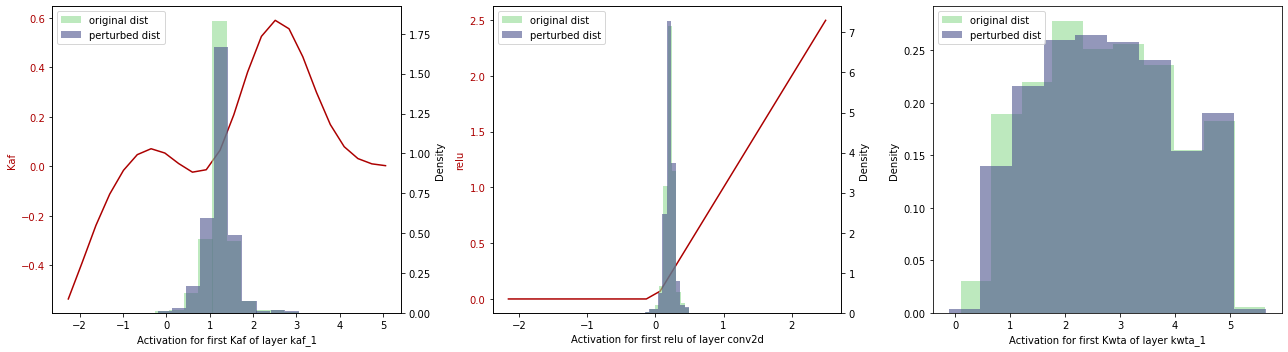

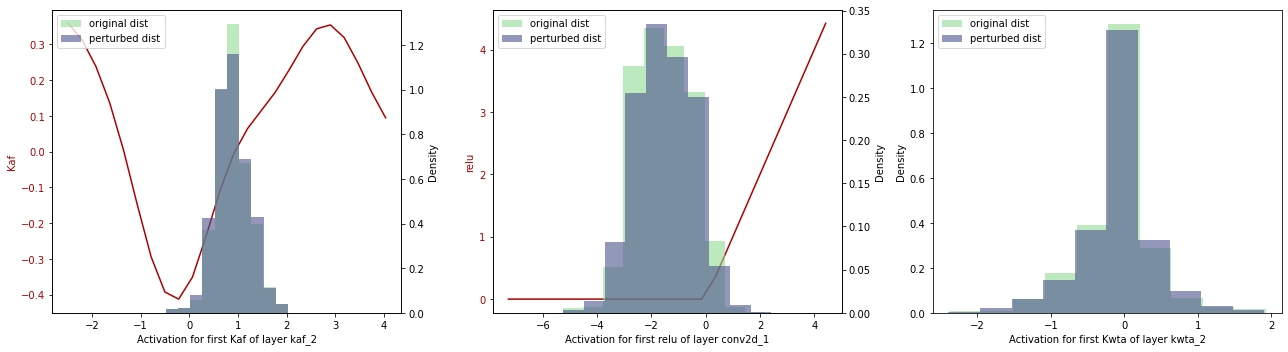

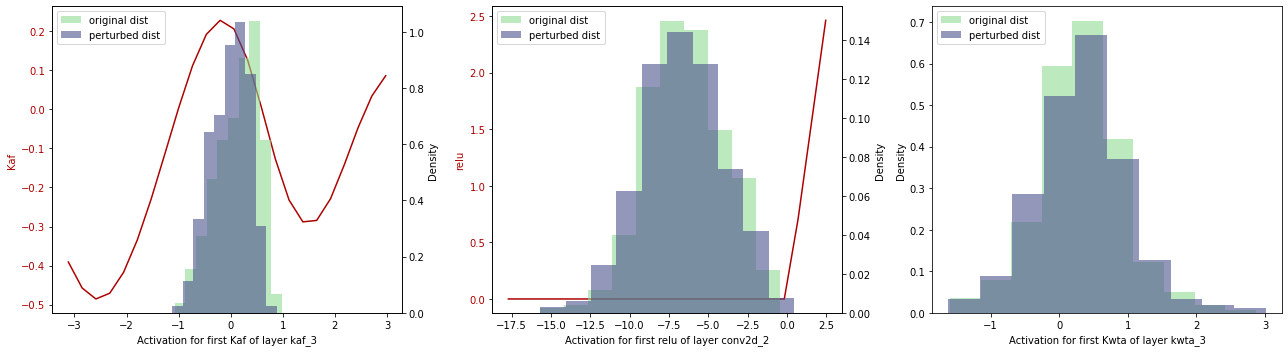

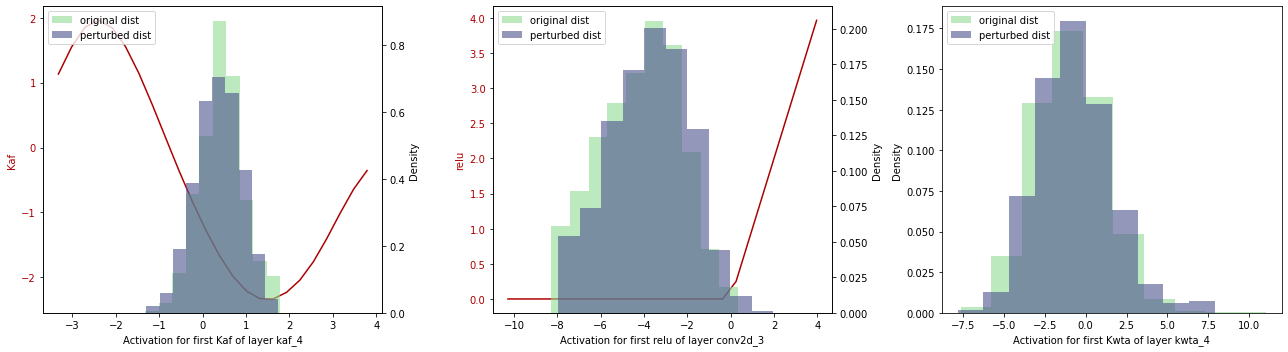

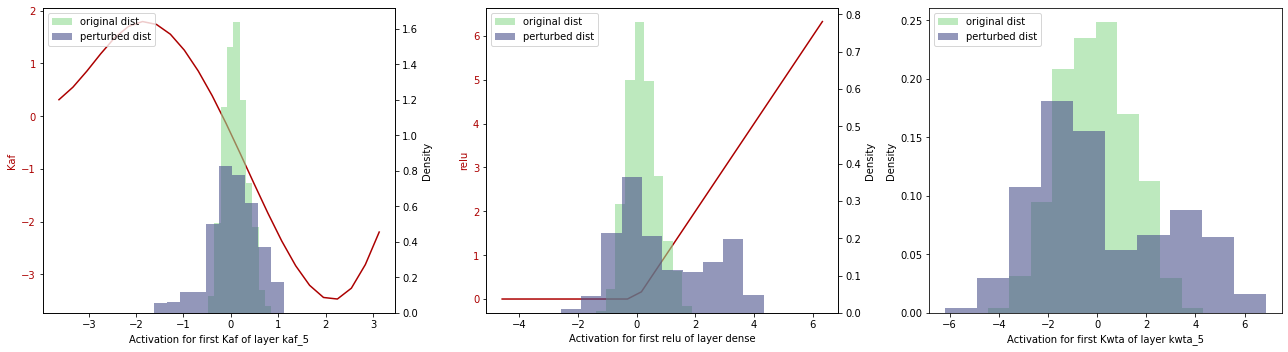

In [19]:
# Display the distribution of the activation value of a specific neuron, for each layer
# Here we just pick always the first(0) neuron, but it should be made many times with different neurons to understand what is going on

first = True
last = 5

for i in range(1, 6): # For each layer
  
  # Get activation function's layer names
  kaf_name = 'kaf_'+str(i)
  kwta_name = 'kwta_'+str(i)
  if first:
    fixed_name = 'conv2d'
    first =False
  elif i == last:
    fixed_name = 'dense'
  else: # In between
    fixed_name = 'conv2d_'+str(i-1)

  # Get the activations to the current (for relu and kwta and kaf) layer when evaluating both original examples and the respective adversarial ones
  relu_inp_orgn = get_hidden_layer_input(relu_cnn, fixed_name, relu_test_sample, fixed = True)
  relu_inp_prt = get_hidden_layer_input(relu_cnn, fixed_name, relu_x_adv, fixed = True)
  
  kwta_inp_orgn = get_hidden_layer_input(kwta_cnn, kwta_name, kwta_test_sample)
  kwta_inp_prt = get_hidden_layer_input(kwta_cnn, kwta_name, kwta_x_adv)
  
  kaf_inp_orgn = get_hidden_layer_input(kaf_cnn, kaf_name, kaf_test_sample)
  kaf_inp_prt = get_hidden_layer_input(kaf_cnn, kaf_name, kaf_x_adv)

  if kaf_inp_orgn.ndim == 4: # If the a.f. is applied on a Conv2d layer
    
    # Get the batch of first activations for the first channel
    relu_act_orgn = relu_inp_orgn[:, 0, 0, 0]
    relu_act_prt = relu_inp_prt[:, 0, 0, 0]

    kwta_act_orgn = kwta_inp_orgn[:, 0, 0, 0]
    kwta_act_prt = kwta_inp_prt[:, 0, 0, 0]

    kaf_act_orgn = kaf_inp_orgn[:, 0, 0, 0]
    kaf_act_prt = kaf_inp_prt[:, 0, 0, 0]
    
  else: # Dense layer otherwise
    
    # Get the batch of activations for the first neuron
    relu_act_orgn = relu_inp_orgn[:, 0]
    relu_act_prt = relu_inp_prt[:, 0]

    kwta_act_orgn = kwta_inp_orgn[:, 0]
    kwta_act_prt = kwta_inp_prt[:, 0]

    kaf_act_orgn = kaf_inp_orgn[:, 0]
    kaf_act_prt = kaf_inp_prt[:, 0]

  # Get mixing coefficients from the first kaf of the layer
  layer = kaf_cnn.get_layer(name = kaf_name)
  a = tf.cast( tf.expand_dims(tf.squeeze(layer.a)[0], 0), dtype = tf.float16 )

  # Input to the activation function to plot a smooth curve
  relu_act = np.concatenate((relu_act_orgn,relu_act_prt))
  min, max = np.min(relu_act), np.max(relu_act)
  relux = np.linspace(min - 2, max + 2, num=24, dtype=np.float16)
  
  kaf_act = np.concatenate((kaf_act_orgn,kaf_act_prt))
  min, max = np.min(kaf_act), np.max(kaf_act)
  kafx = np.linspace(min - 2, max + 2, num=24, dtype=np.float16)
  
  # Compute Kaf and relu over x
  relu = tf.keras.activations.relu(relux)
  kaf = activationsf.kafActivation(tf.expand_dims(kafx,-1), a, d, kb)
  
  # Plot side by side activation visualizations
  fig, axes = plt.subplots(nrows=1, ncols =3, figsize=(18, 5))
  clr_af = '#ac0000' # function color
  clr_orgn = '#92db93' # orginal activation bins color
  clr_prt = '#4c528c'  # perturbed activation bins color
  
  # Handle Kaf case
  axes[0].set_xlabel('Activation for first Kaf of layer {}'.format(kaf_name))
  axes[0].set_ylabel('Kaf', color=clr_af)
  axes[0].plot(kafx, kaf, color=clr_af)
  axes[0].tick_params(axis='y', labelcolor=clr_af)

  ax01 = axes[0].twinx()  # instantiate a second axes that shares the same x-axis
  ax01.set_ylabel('Density')  # we already handled the x-label with axes0
  ax01.hist(kaf_act_orgn, density=True, color=clr_orgn, bins=10, alpha=0.6, label='original dist')
  ax01.hist(kaf_act_prt, density=True, color=clr_prt, bins=10, alpha=0.6, label='perturbed dist')
  ax01.legend(loc='upper left')
  ax01.tick_params(axis='y')

  # Handle relu case
  axes[1].set_xlabel('Activation for first relu of layer {}'.format(fixed_name))
  axes[1].set_ylabel('relu', color=clr_af)
  axes[1].plot(relux, relu, color=clr_af)
  axes[1].tick_params(axis='y', labelcolor=clr_af)

  ax11 = axes[1].twinx()
  ax11.set_ylabel('Density') 
  ax11.hist(relu_act_orgn, density=True, color=clr_orgn, bins=10, alpha=0.6, label='original dist')
  ax11.hist(relu_act_prt, density=True, color=clr_prt, bins=10, alpha=0.6, label='perturbed dist')
  ax11.legend(loc='upper left')
  ax11.tick_params(axis='y')

  # Handle KWTA case
  # Note: KWTA cant be plotted, show only activation distributions
  axes[2].set_xlabel('Activation for first Kwta of layer {}'.format(kwta_name))
  axes[2].set_ylabel('Density') 
  axes[2].hist(kwta_act_orgn, density=True, color=clr_orgn, bins=10, alpha=0.6, label='original dist')
  axes[2].hist(kwta_act_prt, density=True, color=clr_prt, bins=10, alpha=0.6, label='perturbed dist')
  axes[2].legend(loc='upper left')
  axes[2].tick_params(axis='y')

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.show()
  plt.close()

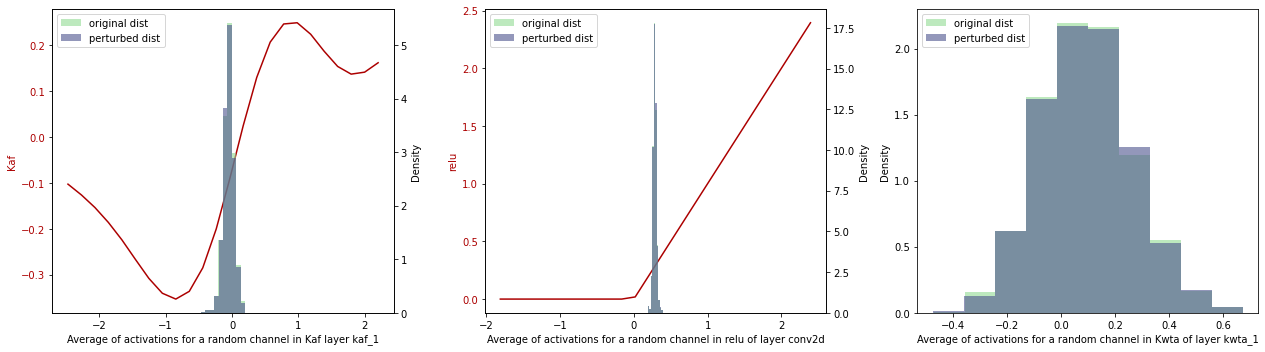

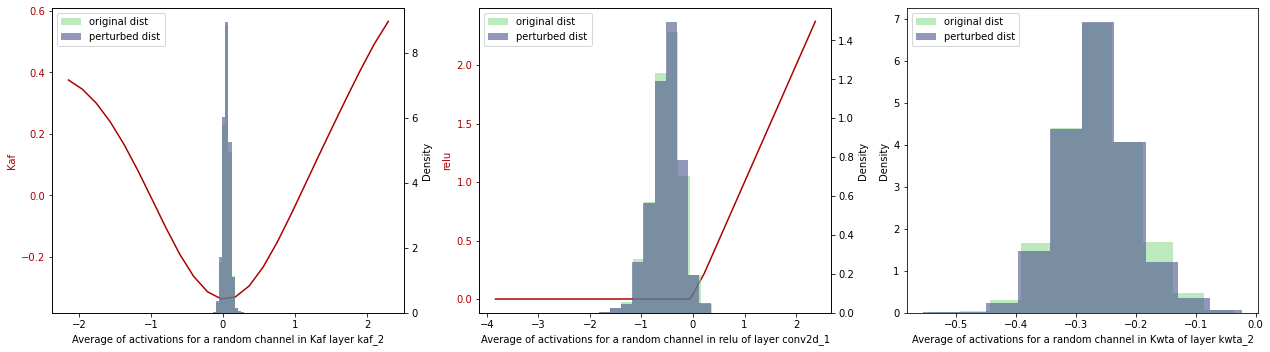

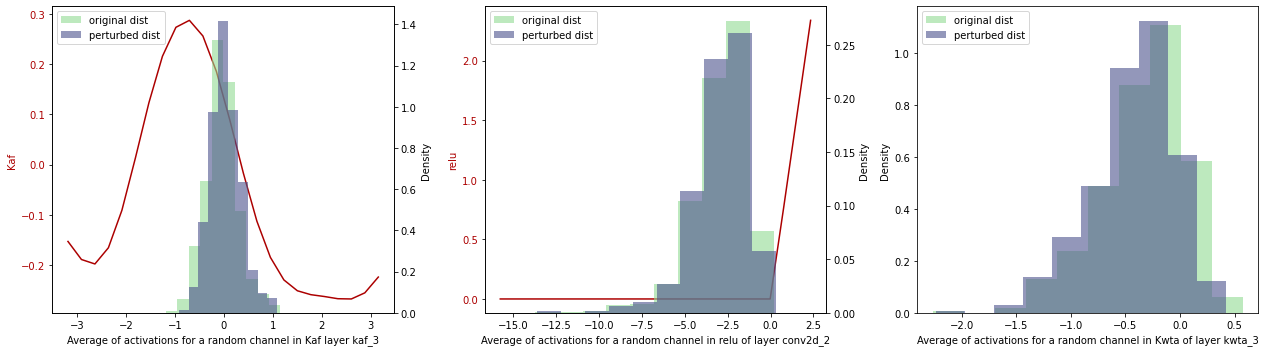

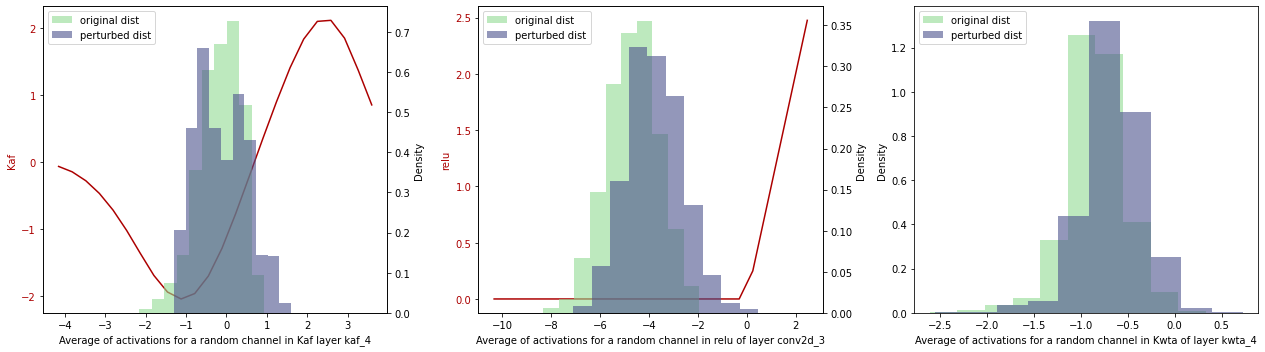

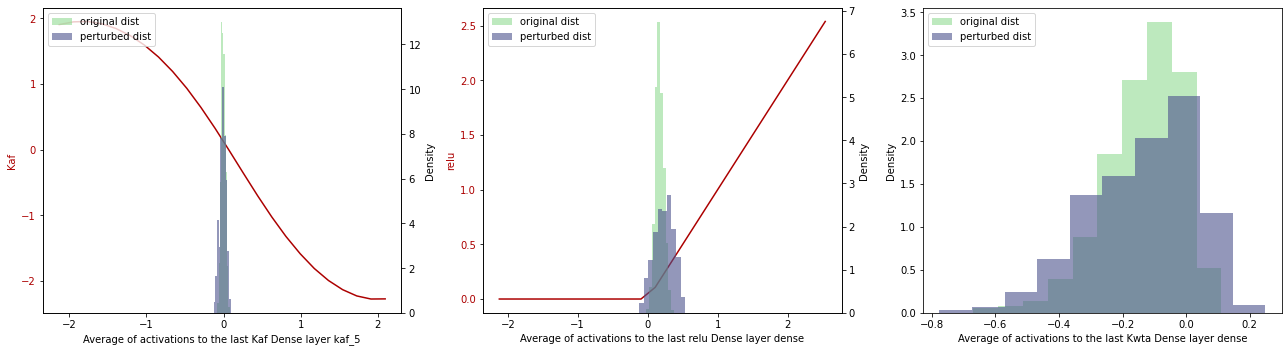

In [14]:
# Here insted we plot the distribution of the average value of a specific channel, for each convolutive layer, same as before otherwise
# Again, we picked the 10*i-th channel but it's arbitrary
# Code is the same as the previous cell except for using a Global average pooling to take the mean value 

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # Mute some useless warnings


first = True
last = 5

for i in range(1, 6): # For each activation function 
  
  # Get activation function's layer names
  kaf_name = 'kaf_'+str(i)
  kwta_name = 'kwta_'+str(i)
  if first:
    fixed_name = 'conv2d'
    first =False
  elif i == last:
    fixed_name = 'dense'
  else: # In between
    fixed_name = 'conv2d_'+str(i-1)

  # Get the batch of inputs when predicting the original sample of images and the perturbed ones
  relu_inp_orgn = get_hidden_layer_input(relu_cnn, fixed_name, relu_test_sample, fixed = True)
  relu_inp_prt = get_hidden_layer_input(relu_cnn, fixed_name, relu_x_adv, fixed = True)
  
  kwta_inp_orgn = get_hidden_layer_input(kwta_cnn, kwta_name, kwta_test_sample)
  kwta_inp_prt = get_hidden_layer_input(kwta_cnn, kwta_name, kwta_x_adv)
  
  kaf_inp_orgn = get_hidden_layer_input(kaf_cnn, kaf_name, kaf_test_sample)
  kaf_inp_prt = get_hidden_layer_input(kaf_cnn, kaf_name, kaf_x_adv)

  if kaf_inp_orgn.ndim == 4: # If the a.f. is applied on a Conv2d layer
    
    # Get the average batch of activations for the 10*i-th channel
    relu_act_orgn = tf.keras.layers.GlobalAveragePooling2D()(relu_inp_orgn)[:, 10*i]
    relu_act_prt = tf.keras.layers.GlobalAveragePooling2D()(relu_inp_prt)[:, 10*i]

    kwta_act_orgn = tf.keras.layers.GlobalAveragePooling2D()(kwta_inp_orgn)[:, 10*i]
    kwta_act_prt = tf.keras.layers.GlobalAveragePooling2D()(kwta_inp_prt)[:, 10*i]

    kaf_act_orgn = tf.keras.layers.GlobalAveragePooling2D()(kaf_inp_orgn)[:, 10*i]
    kaf_act_prt = tf.keras.layers.GlobalAveragePooling2D()(kaf_inp_prt)[:, 10*i]
    
  else: # Dense layer otherwise
    
    # Get the mean average batch of activations in the last layer
    relu_act_orgn = tf.math.reduce_mean(relu_inp_orgn, axis=1)
    relu_act_prt = tf.math.reduce_mean(relu_inp_prt, axis=1)

    kwta_act_orgn = tf.math.reduce_mean(kwta_inp_orgn, axis=1)
    kwta_act_prt = tf.math.reduce_mean(kwta_inp_prt, axis=1)

    kaf_act_orgn = tf.math.reduce_mean(kaf_inp_orgn, axis=1)
    kaf_act_prt = tf.math.reduce_mean(kaf_inp_prt, axis=1)

  # Get mixing coefficients from the first kaf of the layer
  layer = kaf_cnn.get_layer(name = kaf_name)
  a = tf.cast( tf.expand_dims(tf.squeeze(layer.a)[10*i], 0), dtype = tf.float16 )

  # Input to the activation function to plot a smooth curve
  relu_act = np.concatenate((relu_act_orgn,relu_act_prt))
  min, max = np.min(relu_act), np.max(relu_act)
  relux = np.linspace(min - 2, max + 2, num=24, dtype=np.float16)
  
  kaf_act = np.concatenate((kaf_act_orgn,kaf_act_prt))
  min, max = np.min(kaf_act), np.max(kaf_act)
  kafx = np.linspace(min - 2, max + 2, num=24, dtype=np.float16)
  
  # Compute Kaf and relu over x
  relu = tf.keras.activations.relu(relux)
  kaf = activationsf.kafActivation(tf.expand_dims(kafx,-1), a, d, kb)
  
  # Plot side by side activation visualizations
  fig, axes = plt.subplots(nrows=1, ncols =3, figsize=(18, 5))
  clr_af = '#ac0000' # function color
  clr_orgn = '#92db93' # orginal activation bins color
  clr_prt = '#4c528c'  # perturbed activation bins color
  
  # Handle Kaf case
  if kaf_inp_orgn.ndim == 4:
    axes[0].set_xlabel('Average of activations for a random channel in Kaf layer {}'.format(kaf_name))
  else:  
    axes[0].set_xlabel('Average of activations to the last Kaf Dense layer {}'.format(kaf_name))
  axes[0].set_ylabel('Kaf', color=clr_af)
  axes[0].plot(kafx, kaf, color=clr_af)
  axes[0].tick_params(axis='y', labelcolor=clr_af)

  ax01 = axes[0].twinx()  # instantiate a second axes that shares the same x-axis
  ax01.set_ylabel('Density')  # we already handled the x-label with axes0
  ax01.hist(kaf_act_orgn, density=True, color=clr_orgn, bins=10, alpha=0.6, label='original dist')
  ax01.hist(kaf_act_prt, density=True, color=clr_prt, bins=10, alpha=0.6, label='perturbed dist')
  ax01.legend(loc='upper left')
  ax01.tick_params(axis='y')

  # Handle relu case
  if kaf_inp_orgn.ndim == 4:
    axes[1].set_xlabel('Average of activations for a random channel in relu of layer {}'.format(fixed_name))
  else:
    axes[1].set_xlabel('Average of activations to the last relu Dense layer {}'.format(fixed_name))
  axes[1].set_ylabel('relu', color=clr_af)
  axes[1].plot(relux, relu, color=clr_af)
  axes[1].tick_params(axis='y', labelcolor=clr_af)

  ax11 = axes[1].twinx()
  ax11.set_ylabel('Density') 
  ax11.hist(relu_act_orgn, density=True, color=clr_orgn, bins=10, alpha=0.6, label='original dist')
  ax11.hist(relu_act_prt, density=True, color=clr_prt, bins=10, alpha=0.6, label='perturbed dist')
  ax11.legend(loc='upper left')
  ax11.tick_params(axis='y')

  # Handle KWTA case
  # Note: KWTA cant be plotted, show only activation distributions
  if kaf_inp_orgn.ndim == 4:
    axes[2].set_xlabel('Average of activations for a random channel in Kwta of layer {}'.format(kwta_name))
  else:
    axes[2].set_xlabel('Average of activations to the last Kwta Dense layer {}'.format(fixed_name))
  axes[2].set_ylabel('Density') 
  axes[2].hist(kwta_act_orgn, density=True, color=clr_orgn, bins=10, alpha=0.6, label='original dist')
  axes[2].hist(kwta_act_prt, density=True, color=clr_prt, bins=10, alpha=0.6, label='perturbed dist')
  axes[2].legend(loc='upper left')
  axes[2].tick_params(axis='y')

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.show()
  plt.close()


## Considerations: It appears that the biggest deviation between orginal and adversarial activations occurs in the last layer, the Dense one before softmax, wihch does make sense if we consider the drop in accuracy when we evaluate on adversarial examples

## In particular, this very raw analysis, seems to suggest that KAF activations are somehow less prone big changes when the input is corrupted

## To quantify, compute, for each hidden layer and activation function, an estimation of the difference in the output when we are evaluating original and adversarial examples.

In [19]:
# To get yourself convinced that the least deviation is obtained when we are dealing with kafs, try many run of this cell
# changing everytime the sample being, tested. For example now is set to 500, but you could pick any from 0 to 999

first = True
last = 5
for i in range(1, 6): # For each layer 
  
  # Get activation function's layer names
  kaf_name = 'kaf_'+str(i)
  kwta_name = 'kwta_'+str(i)
  if first:
    fixed_name = 'conv2d'
    first =False
  elif i == last:
    fixed_name = 'dense'
  else: # In between
    fixed_name = 'conv2d_'+str(i-1)

  # Get the output of the current (for elu and kwta and kaf) layer when predicting both an original example and the respective adversarial one
  relu_out_orgn = get_hidden_layer_output(relu_cnn, fixed_name, tf.expand_dims(relu_test_sample[500], 0)) 
  relu_out_prt = get_hidden_layer_output(relu_cnn, fixed_name, tf.expand_dims(relu_x_adv[500], 0))
  
  kwta_out_orgn = get_hidden_layer_output(kwta_cnn, kwta_name, tf.expand_dims(kwta_test_sample[500], 0))
  kwta_out_prt = get_hidden_layer_output(kwta_cnn, kwta_name, tf.expand_dims(kwta_x_adv[500], 0))
  
  kaf_out_orgn = get_hidden_layer_output(kaf_cnn, kaf_name, tf.expand_dims(kaf_test_sample[500], 0))
  kaf_out_prt = get_hidden_layer_output(kaf_cnn, kaf_name, tf.expand_dims(kaf_x_adv[500], 0))

  if kaf_out_orgn.ndim == 4: # If the a.f. is applied on a Conv2d layer
    
    # Get the average of the output from each channel
    relu_out_orgn = tf.keras.layers.GlobalAveragePooling2D()(relu_out_orgn)
    relu_out_prt = tf.keras.layers.GlobalAveragePooling2D()(relu_out_prt)

    kwta_out_orgn = tf.keras.layers.GlobalAveragePooling2D()(kwta_out_orgn)
    kwta_out_prt = tf.keras.layers.GlobalAveragePooling2D()(kwta_out_prt)

    kaf_out_orgn = tf.keras.layers.GlobalAveragePooling2D()(kaf_out_orgn)
    kaf_out_prt = tf.keras.layers.GlobalAveragePooling2D()(kaf_out_prt)
    
  # Compute and print the difference in the outputs of original and adversarial example as a mean squared error sum
  relu_diff = np.sum((relu_out_orgn - relu_out_prt)**2)
  kaf_diff = np.sum((kaf_out_orgn - kaf_out_prt)**2)
  kwta_diff = np.sum((kwta_out_orgn - kwta_out_prt)**2)
  print("Perturbation Effects at layer {}: relu {}; KAF {}; KWTA {}".format(i, relu_diff, kaf_diff, kwta_diff))

Perturbation Effects at layer 1: relu 1.9470837287371978e-05; KAF 0.000389094086131081; KWTA 0.005003220867365599
Perturbation Effects at layer 2: relu 0.21630991995334625; KAF 0.00674467533826828; KWTA 0.010555669665336609
Perturbation Effects at layer 3: relu 8.255816459655762; KAF 0.07087618112564087; KWTA 0.06470988690853119
Perturbation Effects at layer 4: relu 1.6892420053482056; KAF 15.263426780700684; KWTA 23.66370964050293
Perturbation Effects at layer 5: relu 181.02540588378906; KAF 140.5; KWTA 157.74923706054688
